In [1]:
import os
from datetime import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import csv
from csv import writer



#tensorflow import
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam

#logging
from tensorflow import keras
from keras import backend as K


#custom functions import
from ts_functions import time_window_generator
from aux_functions import aux_functions


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [6]:
# config 

mom_test = {
    "log_file" : "training_log/mom.csv",
    "training_file" : "stock_data\mom.csv"
}


tencent = {
    "log_file" : "training_log/tencent_t1.csv",
    "training_file" : "stock_data\tencent_10_22_day.csv"
}


In [3]:
config = mom_test

In [4]:
#option flags
debug_mode = True
debug_output_n = 2

performance_log = True
data_log_csv_path = config.get("log_file")


#tensorboard logging doesnt work for now
tf_log_dir = "logs/LSTM_stocks/"




In [5]:
print(config.keys())

dict_keys(['log_file', 'training_file'])


In [6]:
fileDir = os.path.dirname(os.path.realpath('__file__'))
filename = os.path.join(fileDir, config.get("training_file")) #stock data

In [7]:
drop_list = ['change']

df = pd.read_csv(filename).drop(drop_list, axis=1)

In [8]:
if debug_mode:
    display(df)

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
0,300014.SZ,20220825,109.02,109.98,102.51,104.85,108.48,-3.3462,346015.16,3624819.986
1,300014.SZ,20220824,121.50,121.80,107.00,108.48,117.88,-7.9742,522167.78,5850983.970
2,300014.SZ,20220823,116.82,121.69,116.82,117.88,116.05,1.5769,305979.14,3643789.126
3,300014.SZ,20220822,110.80,117.00,108.33,116.05,110.80,4.7383,304361.63,3486174.658
4,300014.SZ,20220819,114.01,114.44,110.00,110.80,113.13,-2.0596,274966.12,3072711.377
...,...,...,...,...,...,...,...,...,...,...
8172,600323.SH,20010108,16.45,16.52,16.00,16.03,16.45,-2.5500,41757.96,67371.813
8173,600323.SH,20010105,16.40,16.75,16.30,16.45,16.38,0.4300,37375.18,61497.502
8174,600323.SH,20010104,16.00,16.65,15.75,16.38,15.94,2.7600,63529.11,103511.364
8175,600323.SH,20010103,15.80,16.18,15.42,15.94,15.80,0.8900,63049.19,99557.012


In [9]:
if debug_mode:
    display(df.describe())

,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
count,8.177000e+03,8177.000000,8177.000000,8177.000000,8177.000000,8177.00000,8177.000000,8.177000e+03,8.177000e+03
mean,2.013087e+07,22.006337,22.522665,21.530248,22.023663,22.00029,0.122851,9.244201e+04,3.459993e+05
std,5.875486e+04,20.873017,21.504713,20.246461,20.848680,20.82181,3.276732,1.186634e+05,7.887002e+05
min,2.001010e+07,5.700000,5.880000,5.650000,5.720000,5.72000,-15.855000,2.940000e+02,2.755030e+02
25%,2.009082e+07,11.480000,11.720000,11.240000,11.490000,11.49000,-1.340000,2.094784e+04,2.551562e+04
50%,2.014030e+07,15.170000,15.440000,14.950000,15.190000,15.19000,0.070000,4.953396e+04,7.811151e+04
75%,2.018061e+07,22.910000,23.400000,22.490000,22.940000,22.90000,1.490000,1.137756e+05,2.116072e+05
max,2.022082e+07,150.050000,152.900000,145.760000,148.750000,148.75000,140.440000,1.509650e+06,9.053106e+06


# Model DataFrame preprocessing

In [8]:
#split data into different stock
# stock_list = [x.sort_values("trade_date", ascending = True) for _,x in df.groupby('ts_code')]


stock_list = []

for ts_code, x in df.groupby('ts_code'):
    stock_list.append(x.copy().sort_values("trade_date", ascending = True).reset_index().drop('index', axis=1))




#sort by trade_date, ascending
if debug_mode:
    print("number of stocks : ", len(stock_list))

UsageError: Line magic function `%%time` not found.


# ADD HSI into the df

In [11]:
# hsi_filename = os.path.join(fileDir, r"stock_data\hsi_07_22_day.csv")

# df_hsi = pd.read_csv(hsi_filename).drop(['index_ts_code', 'index_vol', 'index_change', 'index_vol', 'index_swing'], axis=1).sort_values("index_trade_date", ascending = True).reset_index().drop('index', axis=1)

# display(df_hsi)

In [12]:
# #append hs300 by matching dates
# invalid_stock_list = []# the stock that is fucked


# for i in range(len(stock_list)):
#     stock = stock_list[i]
#     if stock['trade_date'].iloc[-1] != df_hs300['index_trade_date'].iloc[-1]:
#         invalid_stock_list.append(i)


In [13]:
# # for i in invalid_stock_list:
# #     print(stock_list[i].head(1))

# invalid_stock_list = sorted(invalid_stock_list, reverse=True)

# print(invalid_stock_list)


# for i in invalid_stock_list:
#     stock_list.pop(i)

In [14]:
# stock_list[0]['trade_date']
# print(len(stock_list[0]['trade_date']))

# tx = df_hsi[df_hsi['index_trade_date'].isin(stock_list[0]['trade_date'])].sort_values("index_trade_date", ascending = True).reset_index().drop('index', axis=1)
# display(tx)

# display(stock_list[0])

# display(df_hsi)

# txp = pd.concat([stock_list[0], tx], axis=1, join='inner')
# display(txp)

In [15]:
# #concat

# for i in range(len(stock_list)):

#     temp = df_hsi[df_hsi['index_trade_date'].isin(stock_list[i]['trade_date'])].sort_values("index_trade_date", ascending = True).reset_index().drop('index', axis=1)
#     stock_list[i] = pd.concat([stock_list[i], temp], axis=1, join='inner')#.drop('index_trade_date', axis=1)

#     # stock_list[i] = stock_list[i].join(df_hsi, on='str', lsuffix='trade_date', rsuffix='index_trade_date', how='inner')





In [16]:
# display(stock_list[0])

In [17]:
#check time matching
# for stock in stock_list:
#     print(stock['trade_date'].isin(stock['index_trade_date']).value_counts())

In [18]:
display(stock_list[0][0:15])

,ts_code,trade_date,open,high,low,close,pre_close,pct_chg,vol,amount
0,300014.SZ,20091030,38.00,57.00,36.00,43.28,18.00,140.44,157364.07,662705.7618
1,300014.SZ,20091102,38.95,41.22,38.95,38.95,43.28,-10.00,59403.56,232898.4629
2,300014.SZ,20091103,38.00,39.93,36.00,37.77,38.95,-3.03,54480.19,207819.1483
3,300014.SZ,20091104,38.20,40.50,38.18,39.86,37.77,5.53,50126.28,197219.7493
4,300014.SZ,20091105,39.10,41.77,38.32,39.92,39.86,0.15,47093.50,188182.4578
5,300014.SZ,20091106,39.70,39.94,38.53,38.90,39.92,-2.56,27134.93,106007.7956
6,300014.SZ,20091109,38.84,38.87,37.39,37.93,38.90,-2.49,21946.99,83284.8133
7,300014.SZ,20091110,38.30,38.30,36.60,36.74,37.93,-3.14,26857.88,100151.9652
8,300014.SZ,20091111,36.87,38.50,36.63,38.28,36.74,4.19,25282.65,95016.9852
9,300014.SZ,20091112,38.00,39.49,37.72,38.47,38.28,0.50,23543.01,90822.8381


# add time periodicity

In [9]:
#setup timestamp for year periodicity 

date_time_db = []

for stock_i in stock_list:
    date_time_db.append(pd.to_datetime(stock_i.pop('trade_date'), format='%Y%m%d'))

UsageError: Line magic function `%%time` not found.


In [20]:
if debug_mode:
    print(date_time_db[0])

0      2009-10-30
1      2009-11-02
2      2009-11-03
3      2009-11-04
4      2009-11-05
          ...    
3052   2022-08-19
3053   2022-08-22
3054   2022-08-23
3055   2022-08-24
3056   2022-08-25
Name: trade_date, Length: 3057, dtype: datetime64[ns]


In [21]:
date_time_stamp_db = []

for dt in date_time_db:
    date_time_stamp_db.append(dt.map(pd.Timestamp.timestamp))

In [22]:
if debug_mode:
    date_time_stamp_db[0]

In [23]:
year = 24*60*60*(365.2425)

for i in range(len(stock_list)):
    
    stock_list[i]["Year sin"] = np.sin(date_time_stamp_db[i] * (2 * np.pi / year))
    stock_list[i]["Year cos"] = np.cos(date_time_stamp_db[i] * (2 * np.pi / year))
    

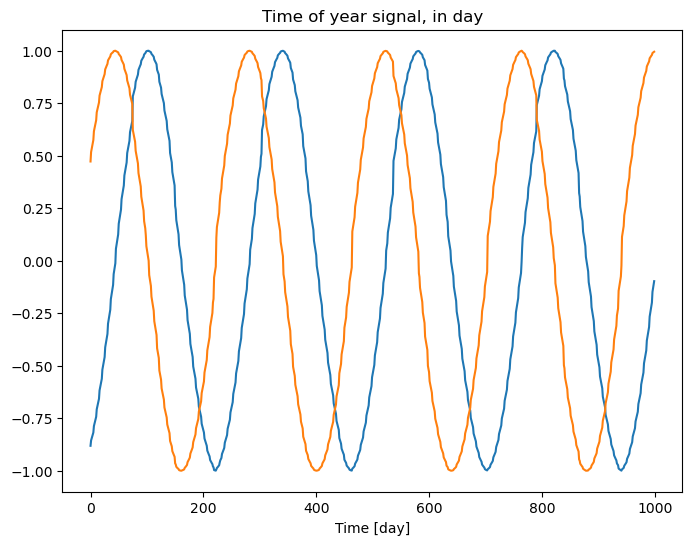

In [24]:
if debug_mode:
    plt.plot(np.array(stock_list[0]['Year sin'])[:1000])
    plt.plot(np.array(stock_list[0]['Year cos'])[:1000])
    plt.xlabel('Time [day]')
    plt.title('Time of year signal, in day')

In [25]:
if debug_mode:
    display(stock_list[0].head())

,ts_code,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos
0,300014.SZ,38.00,57.00,36.00,43.28,18.00,140.44,157364.07,662705.7618,-0.881304,0.472550
1,300014.SZ,38.95,41.22,38.95,38.95,43.28,-10.00,59403.56,232898.4629,-0.855754,0.517383
2,300014.SZ,38.00,39.93,36.00,37.77,38.95,-3.03,54480.19,207819.1483,-0.846727,0.532028
3,300014.SZ,38.20,40.50,38.18,39.86,37.77,5.53,50126.28,197219.7493,-0.837450,0.546514
4,300014.SZ,39.10,41.77,38.32,39.92,39.86,0.15,47093.50,188182.4578,-0.827925,0.560839


In [26]:
#df processing
for stock in stock_list:
    stock.name = stock.iloc[0,0]
    stock.pop("ts_code") #pop the stock code
    #stock.pop("pre_close") #pop previous day close price

In [27]:
if debug_mode:
    display(stock_list[0].head())

,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos
0,38.00,57.00,36.00,43.28,18.00,140.44,157364.07,662705.7618,-0.881304,0.472550
1,38.95,41.22,38.95,38.95,43.28,-10.00,59403.56,232898.4629,-0.855754,0.517383
2,38.00,39.93,36.00,37.77,38.95,-3.03,54480.19,207819.1483,-0.846727,0.532028
3,38.20,40.50,38.18,39.86,37.77,5.53,50126.28,197219.7493,-0.837450,0.546514
4,39.10,41.77,38.32,39.92,39.86,0.15,47093.50,188182.4578,-0.827925,0.560839


# MA implementation

In [28]:
ma_label = 'open'

In [29]:
for stock in stock_list:
    
    #MA

    processing_row = stock[ma_label].to_frame()

    stock['sma5'] = processing_row[ma_label].rolling(5).mean()

    stock['ema5'] = processing_row[ma_label].ewm(span=5).mean()

    stock['ema20'] = processing_row[ma_label].ewm(span=20).mean()

    stock['ema50'] = processing_row[ma_label].ewm(span=50).mean()

    

    # # Golden Cross  implementation
    # np.where(stock['ema20'] > stock['ema50'], 1, 0)

    # stock['ema20_50_GC'] = 0 

    # for i in range(stock.shape[0]):
    #     if i == 0:
    #         pass
    #     elif stock['ema20'][i] >= stock['ema50'][i] and stock['ema20'][i-1] < stock['ema50'][i-1]: #slow code, works for now
    #         stock['ema20_50_GC'][i] = 1



    stock.dropna(inplace=True)
    

In [30]:
# #GC value count inspction
# for stock in stock_list:
#     print(stock['ema20_50_GC'].value_counts())



In [31]:
display(stock_list[0])

,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4,39.10,41.77,38.32,39.92,39.86,0.1500,47093.50,1.881825e+05,-0.827925,0.560839,38.450,38.581517,38.480047,38.461768
5,39.70,39.94,38.53,38.90,39.92,-2.5600,27134.93,1.060078e+05,-0.818155,0.574998,38.790,38.990226,38.737401,38.689316
6,38.84,38.87,37.39,37.93,38.90,-2.4900,21946.99,8.328481e+04,-0.787404,0.616437,38.768,38.937037,38.756800,38.713510
7,38.30,38.30,36.60,36.74,37.93,-3.1400,26857.88,1.001520e+05,-0.776684,0.629891,38.828,38.716070,38.677840,38.654301
8,36.87,38.50,36.63,38.28,36.74,4.1900,25282.65,9.501699e+04,-0.765733,0.643158,38.562,38.084279,38.387853,38.422878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,114.01,114.44,110.00,110.80,113.13,-2.0596,274966.12,3.072711e+06,-0.732342,-0.680937,107.060,107.961175,101.546256,97.524602
3053,110.80,117.00,108.33,116.05,110.80,4.7383,304361.63,3.486175e+06,-0.766493,-0.642252,109.320,108.907450,102.427565,98.045206
3054,116.82,121.69,116.82,117.88,116.05,1.5769,305979.14,3.643789e+06,-0.777428,-0.628972,111.484,111.544967,103.798273,98.781473
3055,121.50,121.80,107.00,108.48,117.88,-7.9742,522167.78,5.850984e+06,-0.788133,-0.615506,114.784,114.863311,105.484152,99.672395


# Final data check

In [32]:
display(stock_list[0])


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4,39.10,41.77,38.32,39.92,39.86,0.1500,47093.50,1.881825e+05,-0.827925,0.560839,38.450,38.581517,38.480047,38.461768
5,39.70,39.94,38.53,38.90,39.92,-2.5600,27134.93,1.060078e+05,-0.818155,0.574998,38.790,38.990226,38.737401,38.689316
6,38.84,38.87,37.39,37.93,38.90,-2.4900,21946.99,8.328481e+04,-0.787404,0.616437,38.768,38.937037,38.756800,38.713510
7,38.30,38.30,36.60,36.74,37.93,-3.1400,26857.88,1.001520e+05,-0.776684,0.629891,38.828,38.716070,38.677840,38.654301
8,36.87,38.50,36.63,38.28,36.74,4.1900,25282.65,9.501699e+04,-0.765733,0.643158,38.562,38.084279,38.387853,38.422878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,114.01,114.44,110.00,110.80,113.13,-2.0596,274966.12,3.072711e+06,-0.732342,-0.680937,107.060,107.961175,101.546256,97.524602
3053,110.80,117.00,108.33,116.05,110.80,4.7383,304361.63,3.486175e+06,-0.766493,-0.642252,109.320,108.907450,102.427565,98.045206
3054,116.82,121.69,116.82,117.88,116.05,1.5769,305979.14,3.643789e+06,-0.777428,-0.628972,111.484,111.544967,103.798273,98.781473
3055,121.50,121.80,107.00,108.48,117.88,-7.9742,522167.78,5.850984e+06,-0.788133,-0.615506,114.784,114.863311,105.484152,99.672395


# Models Area

In [33]:
# stacked_lstm_1 = Sequential(

#     [

#         LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 1, activation = 'linear') #output 

#     ],

#     name = "simple_stacked_lstm_stock_1"

# )

In [34]:
# stacked_lstm_1_plus = Sequential(

#     [

#         LSTM(units = 64, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         LSTM(units = 64, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
#         Dense(units = 1, activation = 'linear') #output 

#     ],

#     name = "simple_stacked_lstm_stock_1_plus"

# )

# Training for all models

In [35]:
#data storage
evaluation_result = {}


#meta data
labels = ['open']

eval_iteration = 10 #the number of evaluation iterations for individual stock

df instances :  3053
df features :  14


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4,39.10,41.77,38.32,39.92,39.86,0.1500,47093.50,1.881825e+05,-0.827925,0.560839,38.450,38.581517,38.480047,38.461768
5,39.70,39.94,38.53,38.90,39.92,-2.5600,27134.93,1.060078e+05,-0.818155,0.574998,38.790,38.990226,38.737401,38.689316
6,38.84,38.87,37.39,37.93,38.90,-2.4900,21946.99,8.328481e+04,-0.787404,0.616437,38.768,38.937037,38.756800,38.713510
7,38.30,38.30,36.60,36.74,37.93,-3.1400,26857.88,1.001520e+05,-0.776684,0.629891,38.828,38.716070,38.677840,38.654301
8,36.87,38.50,36.63,38.28,36.74,4.1900,25282.65,9.501699e+04,-0.765733,0.643158,38.562,38.084279,38.387853,38.422878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,114.01,114.44,110.00,110.80,113.13,-2.0596,274966.12,3.072711e+06,-0.732342,-0.680937,107.060,107.961175,101.546256,97.524602
3053,110.80,117.00,108.33,116.05,110.80,4.7383,304361.63,3.486175e+06,-0.766493,-0.642252,109.320,108.907450,102.427565,98.045206
3054,116.82,121.69,116.82,117.88,116.05,1.5769,305979.14,3.643789e+06,-0.777428,-0.628972,111.484,111.544967,103.798273,98.781473
3055,121.50,121.80,107.00,108.48,117.88,-7.9742,522167.78,5.850984e+06,-0.788133,-0.615506,114.784,114.863311,105.484152,99.672395


train_df instances :  3053


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4,39.10,41.77,38.32,39.92,39.86,0.1500,47093.50,1.881825e+05,-0.827925,0.560839,38.450,38.581517,38.480047,38.461768
5,39.70,39.94,38.53,38.90,39.92,-2.5600,27134.93,1.060078e+05,-0.818155,0.574998,38.790,38.990226,38.737401,38.689316
6,38.84,38.87,37.39,37.93,38.90,-2.4900,21946.99,8.328481e+04,-0.787404,0.616437,38.768,38.937037,38.756800,38.713510
7,38.30,38.30,36.60,36.74,37.93,-3.1400,26857.88,1.001520e+05,-0.776684,0.629891,38.828,38.716070,38.677840,38.654301
8,36.87,38.50,36.63,38.28,36.74,4.1900,25282.65,9.501699e+04,-0.765733,0.643158,38.562,38.084279,38.387853,38.422878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,114.01,114.44,110.00,110.80,113.13,-2.0596,274966.12,3.072711e+06,-0.732342,-0.680937,107.060,107.961175,101.546256,97.524602
3053,110.80,117.00,108.33,116.05,110.80,4.7383,304361.63,3.486175e+06,-0.766493,-0.642252,109.320,108.907450,102.427565,98.045206
3054,116.82,121.69,116.82,117.88,116.05,1.5769,305979.14,3.643789e+06,-0.777428,-0.628972,111.484,111.544967,103.798273,98.781473
3055,121.50,121.80,107.00,108.48,117.88,-7.9742,522167.78,5.850984e+06,-0.788133,-0.615506,114.784,114.863311,105.484152,99.672395






val_df instances :  610


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
2141,13.68,14.10,13.20,13.24,13.76,-3.7791,192653.43,261746.882,-0.659757,0.751479,13.278,13.315646,12.836936,13.136547
2142,13.01,13.52,12.92,13.42,13.24,1.3595,111106.56,147853.743,-0.646732,0.762717,13.260,13.213764,12.853418,13.131585
2143,13.51,13.57,13.17,13.27,13.42,-1.1177,83683.95,111614.637,-0.633517,0.773729,13.362,13.312509,12.915950,13.146425
2144,13.27,13.34,12.46,12.54,13.27,-5.5011,120484.72,154086.660,-0.620113,0.784512,13.374,13.298340,12.949669,13.151271
2145,12.54,12.78,12.31,12.60,12.54,0.4785,72623.95,91159.265,-0.578818,0.815457,13.202,13.045560,12.910653,13.127299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2746,103.00,105.30,100.98,104.28,103.00,1.2427,217495.78,2251272.725,0.673938,-0.738788,97.408,97.849599,88.918030,85.025524
2747,104.30,104.88,99.60,100.72,104.28,-3.4139,296771.22,3012074.492,0.661129,-0.750272,100.524,99.999733,90.382980,85.781386
2748,102.99,104.00,100.40,102.20,100.72,1.4694,215392.00,2196400.967,0.621546,-0.783378,102.294,100.996488,91.583649,86.456233
2749,102.20,107.39,100.95,107.29,102.18,5.0010,287953.00,3038754.145,0.607979,-0.793953,102.134,101.397659,92.594730,87.073636






test_df instances :  306


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
2751,100.01,100.78,97.50,100.10,102.84,-2.6643,457260.62,4528635.567,0.580308,-0.814397,103.326,102.208960,94.553418,88.336624
2752,101.00,108.84,100.30,103.95,100.10,3.8462,400752.55,4235684.071,0.566213,-0.824259,102.666,101.805973,95.167378,88.833227
2753,106.00,112.04,104.15,111.05,103.95,6.8302,322518.94,3533024.881,0.522939,-0.852370,103.268,103.203982,96.199057,89.506434
2754,109.98,109.98,106.13,107.20,111.05,-3.4669,263886.65,2843221.635,0.508199,-0.861240,104.824,105.462655,97.511527,90.309319
2755,108.60,109.49,105.13,107.11,107.20,-0.0840,190552.17,2037553.267,0.493309,-0.869854,105.118,106.508436,98.567572,91.026601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3052,114.01,114.44,110.00,110.80,113.13,-2.0596,274966.12,3072711.377,-0.732342,-0.680937,107.060,107.961175,101.546256,97.524602
3053,110.80,117.00,108.33,116.05,110.80,4.7383,304361.63,3486174.658,-0.766493,-0.642252,109.320,108.907450,102.427565,98.045206
3054,116.82,121.69,116.82,117.88,116.05,1.5769,305979.14,3643789.126,-0.777428,-0.628972,111.484,111.544967,103.798273,98.781473
3055,121.50,121.80,107.00,108.48,117.88,-7.9742,522167.78,5850983.970,-0.788133,-0.615506,114.784,114.863311,105.484152,99.672395


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['open']
(TensorSpec(shape=(None, 6, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (8, 6, 14)
Labels shape (batch, time, features): (8, 1, 1)
Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Label indices: [29]
Label column name(s): ['open']
(TensorSpec(shape=(None, 29, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (8, 29, 14)
Labels shape (batch, time, features): (8, 1, 1)
Epoch 1/60
378/378 [==============================] - 7s 11ms/step - loss: 0.1791 - mean_absolute_percentage_error: 61.6747 - val_loss: 0.0881 - val_mean_absolute_percentage_error: 23.4152 - lr: 0.0010
Epoch 2/60
378/378 [==============================] - 4s 9ms/step - loss: 0.

,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4,16.45,16.52,16.00,16.03,16.45,-2.5500,41757.96,67371.813,0.128365,0.991727,16.080,16.233412,16.120040,16.096022
5,16.00,16.15,15.90,16.04,16.03,0.0600,17511.13,28049.869,0.145405,0.989372,16.130,16.148120,16.094717,16.078376
6,16.00,16.40,15.97,16.31,16.04,1.6800,17280.48,28039.020,0.162403,0.986725,16.170,16.095678,16.076808,16.065792
7,16.31,16.35,16.03,16.05,16.31,-1.5900,18720.13,30156.149,0.179352,0.983785,16.232,16.170019,16.117117,16.100759
8,16.05,16.10,15.68,15.76,16.05,-1.8100,20428.01,32396.253,0.196249,0.980554,16.162,16.128944,16.106351,16.094175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,20.25,21.90,20.15,21.73,19.94,8.9769,198656.56,423758.060,-0.732342,-0.680937,20.056,20.113824,20.400984,20.373107
5116,21.80,21.96,21.31,21.59,21.73,-0.6443,97476.45,210967.420,-0.766493,-0.642252,20.406,20.675883,20.534224,20.429063
5117,21.70,21.73,21.21,21.45,21.59,-0.6484,64788.63,138855.981,-0.777428,-0.628972,20.704,21.017255,20.645250,20.478904
5118,21.32,21.44,20.66,20.82,21.45,-2.9371,84266.48,176707.863,-0.788133,-0.615506,20.996,21.118170,20.709512,20.511888


train_df instances :  5116


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4,16.45,16.52,16.00,16.03,16.45,-2.5500,41757.96,67371.813,0.128365,0.991727,16.080,16.233412,16.120040,16.096022
5,16.00,16.15,15.90,16.04,16.03,0.0600,17511.13,28049.869,0.145405,0.989372,16.130,16.148120,16.094717,16.078376
6,16.00,16.40,15.97,16.31,16.04,1.6800,17280.48,28039.020,0.162403,0.986725,16.170,16.095678,16.076808,16.065792
7,16.31,16.35,16.03,16.05,16.31,-1.5900,18720.13,30156.149,0.179352,0.983785,16.232,16.170019,16.117117,16.100759
8,16.05,16.10,15.68,15.76,16.05,-1.8100,20428.01,32396.253,0.196249,0.980554,16.162,16.128944,16.106351,16.094175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,20.25,21.90,20.15,21.73,19.94,8.9769,198656.56,423758.060,-0.732342,-0.680937,20.056,20.113824,20.400984,20.373107
5116,21.80,21.96,21.31,21.59,21.73,-0.6443,97476.45,210967.420,-0.766493,-0.642252,20.406,20.675883,20.534224,20.429063
5117,21.70,21.73,21.21,21.45,21.59,-0.6484,64788.63,138855.981,-0.777428,-0.628972,20.704,21.017255,20.645250,20.478904
5118,21.32,21.44,20.66,20.82,21.45,-2.9371,84266.48,176707.863,-0.788133,-0.615506,20.996,21.118170,20.709512,20.511888






val_df instances :  1023


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
3585,12.02,12.09,11.70,11.71,12.18,-3.8600,55862.03,66198.103,0.798681,-0.601754,12.264,12.218376,12.329168,12.464847
3586,11.72,11.82,11.71,11.77,11.71,0.5100,20913.14,24582.829,0.788212,-0.615404,12.190,12.052251,12.271152,12.435637
3587,11.81,11.95,11.66,11.75,11.77,-0.1700,37633.44,44438.862,0.777509,-0.628872,12.072,11.971501,12.227232,12.411102
3588,11.72,11.91,11.53,11.86,11.75,0.9400,49605.05,58351.680,0.766576,-0.642153,11.940,11.887667,12.178925,12.384000
3589,11.79,11.90,11.74,11.79,11.86,-0.5900,26644.63,31534.602,0.755417,-0.655245,11.812,11.855111,12.141884,12.360706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4603,24.46,25.34,23.90,25.00,24.48,2.1242,95915.81,235011.943,-0.209241,-0.977864,24.056,24.062194,23.140359,22.308322
4604,25.10,25.44,24.70,24.87,25.00,-0.5200,82175.90,206426.491,-0.226031,-0.974120,24.494,24.408129,23.326991,22.417800
4605,25.08,26.71,24.73,24.88,24.87,0.0402,135995.68,349530.375,-0.242754,-0.970088,24.590,24.632086,23.493944,22.522200
4606,25.00,26.07,23.75,24.85,24.88,-0.1206,121967.85,303184.150,-0.259406,-0.965768,24.750,24.754724,23.637378,22.619368






test_df instances :  512


,open,high,low,close,pre_close,pct_chg,vol,amount,Year sin,Year cos,sma5,ema5,ema20,ema50
4608,26.55,26.69,25.50,26.38,26.28,0.3805,97330.49,253292.149,-0.325195,-0.945647,25.406,25.474322,24.058035,22.874511
4609,26.27,26.57,25.91,26.15,26.38,-0.8719,78286.85,204914.481,-0.341414,-0.939913,25.640,25.739548,24.268699,23.007667
4610,25.92,26.60,25.52,26.00,26.15,-0.5736,57954.43,150479.768,-0.357532,-0.933901,25.808,25.799699,24.425965,23.121877
4611,26.16,26.98,25.00,25.18,26.00,-3.1538,102629.68,266373.926,-0.373544,-0.927613,26.040,25.919799,24.591112,23.241019
4612,25.25,26.06,24.95,25.31,25.18,0.5163,74847.16,190772.190,-0.420898,-0.907108,26.030,25.696533,24.653863,23.319802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,20.25,21.90,20.15,21.73,19.94,8.9769,198656.56,423758.060,-0.732342,-0.680937,20.056,20.113824,20.400984,20.373107
5116,21.80,21.96,21.31,21.59,21.73,-0.6443,97476.45,210967.420,-0.766493,-0.642252,20.406,20.675883,20.534224,20.429063
5117,21.70,21.73,21.21,21.45,21.59,-0.6484,64788.63,138855.981,-0.777428,-0.628972,20.704,21.017255,20.645250,20.478904
5118,21.32,21.44,20.66,20.82,21.45,-2.9371,84266.48,176707.863,-0.788133,-0.615506,20.996,21.118170,20.709512,20.511888


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['open']
(TensorSpec(shape=(None, 6, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (8, 6, 14)
Labels shape (batch, time, features): (8, 1, 1)
Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
Label indices: [29]
Label column name(s): ['open']
(TensorSpec(shape=(None, 29, 14), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))
Inputs shape (batch, time, features): (8, 29, 14)
Labels shape (batch, time, features): (8, 1, 1)
Epoch 1/60
636/636 [==============================] - 9s 12ms/step - loss: 0.1228 - mean_absolute_percentage_error: 48.9254 - val_loss: 0.0559 - val_mean_absolute_percentage_error: 21.0592 - lr: 0.0010
Epoch 2/60
636/636 [==============================] - 7s 11ms/step - loss: 0

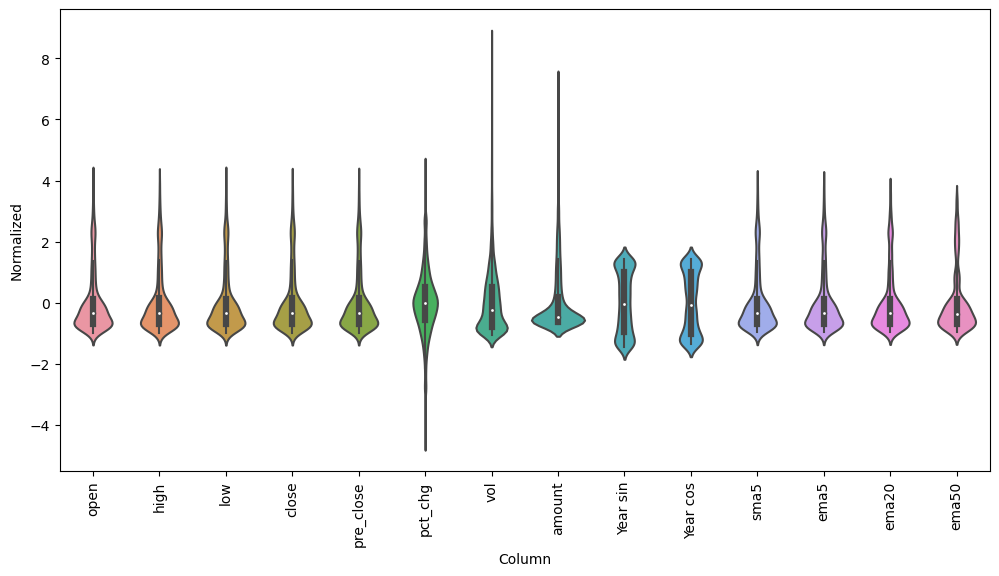

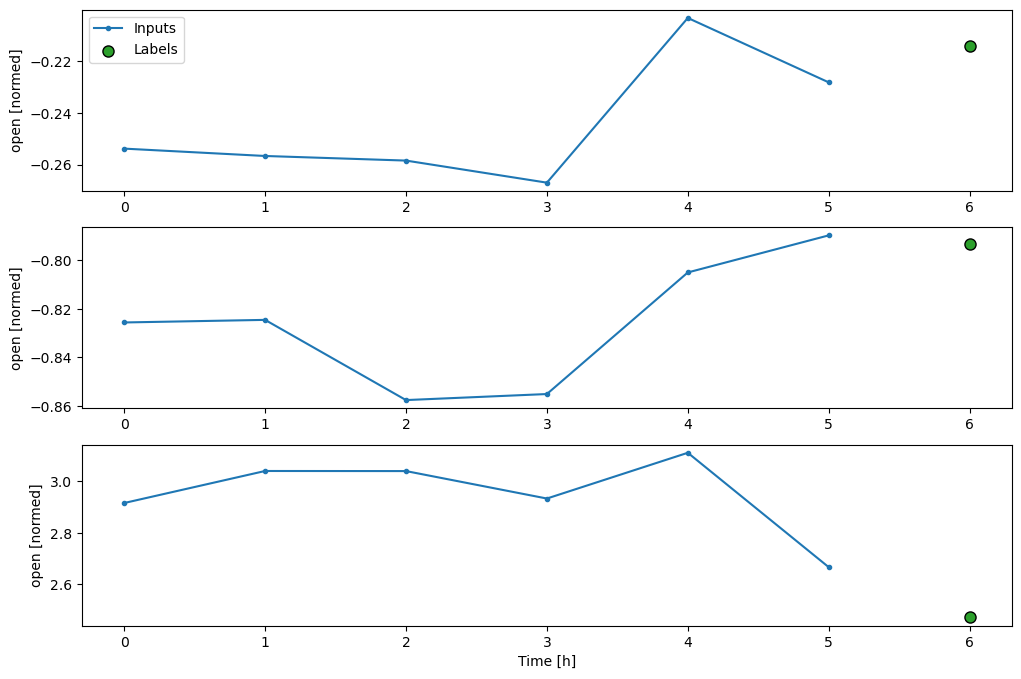

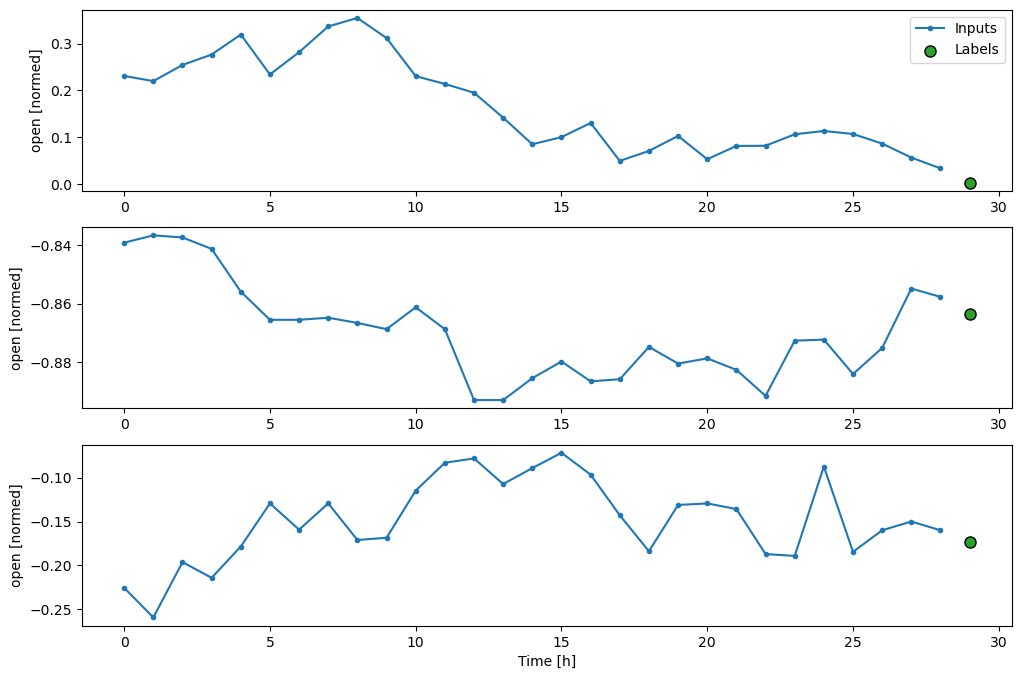

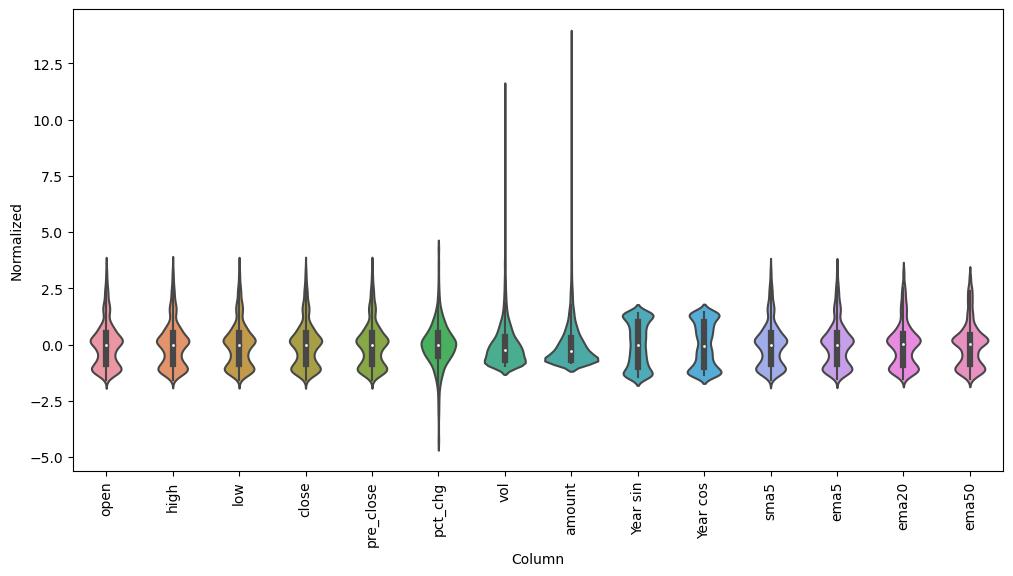

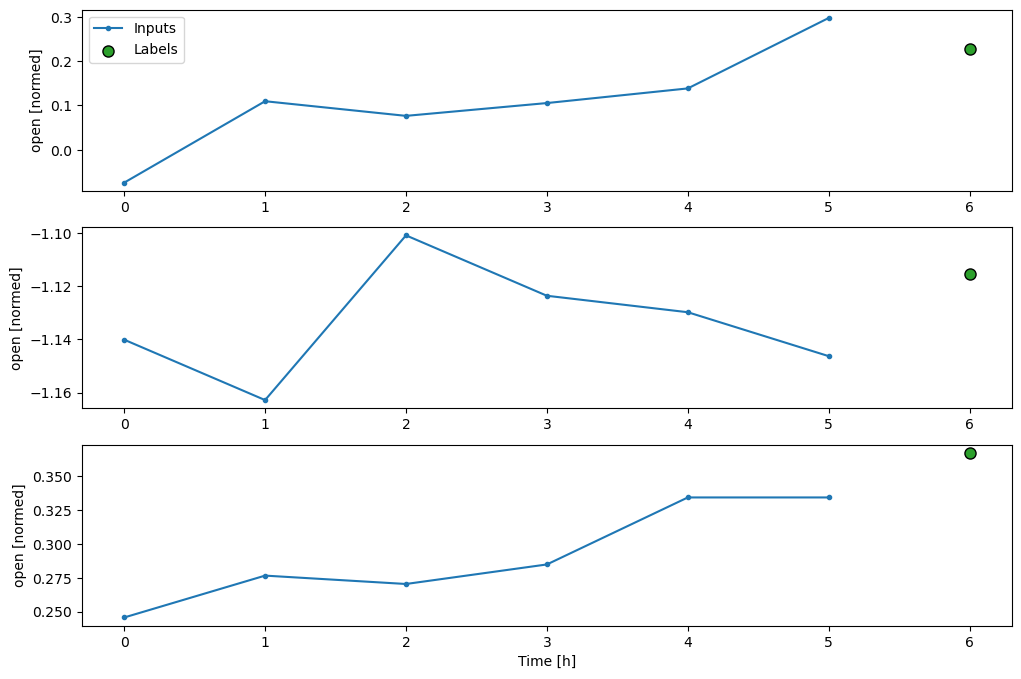

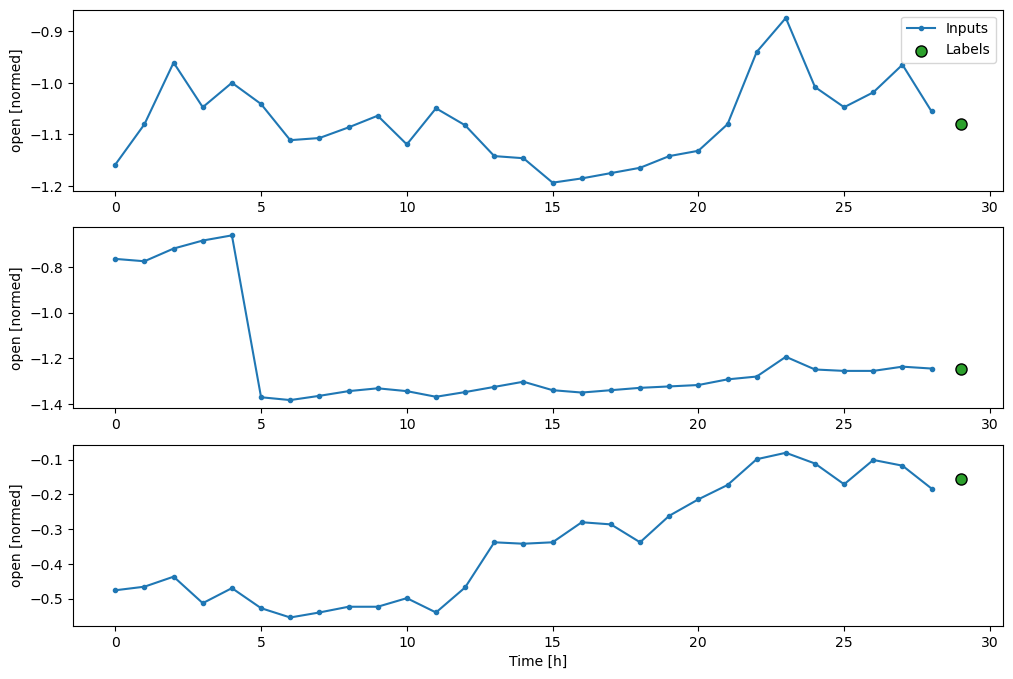

In [36]:



#main training loop
stock_training_range = 5 #len(stock_list)

learning_rate = 0.001

for stock_index in range(len(stock_list)):


    #set up

    current_stock = stock_list[stock_index] #df

    column_indices = {name: i for i, name in enumerate(current_stock.columns)}

    n = len(current_stock)
    num_features = current_stock.shape[1]
    num_row = current_stock.shape[0]

    #split training, cross val and testing data
    #note since this is a time series data, the split is fixed. No randomization
    #no testing data, only cross val data

    train_data_p = 0.7  #percentage of train data
    val_data_p = 0.2

    train_df = current_stock #[ 0 : int(n * train_data_p) ]
    val_df = current_stock[int( n * train_data_p) : int(n * (train_data_p + val_data_p)) ]
    test_df = current_stock[int( n * (train_data_p + val_data_p)) : ]


    #debug area
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        print("df instances : ", num_row)
        print("df features : ", num_features)
        display(current_stock)


    if debug_mode and stock_index < debug_output_n : 
        print("train_df instances : ", len(train_df))
        display(train_df)
        
        for x in range(4): 
            print()
            
        print("val_df instances : ", len(val_df))
        display(val_df)
        
        for x in range(4): 
            print()
            
        print("test_df instances : ", len(test_df))
        display(test_df)
    ########################################################################


    #normalize data
    train_mean = train_df.mean()
    train_std = train_df.std()

    #compute the z score to normalize data between features
    train_df = (train_df - train_mean)/train_std
    val_df = (val_df - train_mean)/train_std
    test_df = (test_df - train_mean)/train_std


    #visuliazation
    ########################################################################
    if debug_mode and stock_index < debug_output_n :
        df_std = (current_stock - train_mean) / train_std
        df_std = df_std.melt(var_name='Column', value_name='Normalized')
        plt.figure(figsize=(12, 6))
        ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
        _ = ax.set_xticklabels(current_stock.keys(), rotation=90)
    ########################################################################



    #window setup area
    ##############################################################################################

    #set up the 7 timesteps window
    win_7 = time_window_generator(input_width = 6, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_7.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_7)
        aux_functions.window_inspection(win_7, debug_mode, labels)
    


    #set up 30 timesteps window
    win_30 = time_window_generator(input_width = 29, label_width = 1, shift = 1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns = labels)
    #set up the batch size
    win_30.batch_size = 8

    if debug_mode and stock_index < debug_output_n :
        print(win_30)
        aux_functions.window_inspection(win_30, debug_mode, labels)

    ##############################################################################################








    #individual stock model performance evaluate 
    result = []



    #train models for n numbers of iteration to check the performance
    for iter in range(eval_iteration):

        #clear backend, prevent memory overflow
        tf.keras.backend.clear_session()

        #tensorboard logging doesnt work for now
        # logpath_exact = tf_log_dir + str(stock_list[stock_index].name) + datetime.now().strftime("%Y%m%d-%H%M%S")
        # tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logpath_exact)


        #temp model area
        ##############################################################################################


        stacked_lstm_1 = Sequential(

            [

                LSTM(units = 32, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                LSTM(units = 32, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 1, activation = 'linear') #output 

            ],

            name = "simple_stacked_lstm_stock_1"

        )



        stacked_lstm_2_multilr = Sequential(

            [

                LSTM(units = 64, activation='tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                LSTM(units = 64, activation='tanh', return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001) ),
                Dense(units = 1, activation = 'linear') #output 

            ],

            name = "simple_stacked_lstm_2_multilr"

        )





        ##############################################################################################



        #chose model to run and evaluate
        train_target = win_30
        train_model = stacked_lstm_2_multilr



        #compile and fit
        data_model = aux_functions.compile_and_fit(train_model, train_target, epochs=60, es_patience=4, es_monitor='val_loss', es_mode='min', lr=learning_rate)


        result.append([train_model.evaluate(train_target.val), train_model.evaluate(train_target.test)])
    




    average_mape_val = 0
    average_mape_test = 0
    
    for result_i in range(len(result)):
        average_mape_val += result[result_i][0][1]
        average_mape_test += result[result_i][1][1]
    
    average_mape_val = average_mape_val/len(result)
    average_mape_test = average_mape_test/len(result)



    evaluation_result[stock_list[stock_index].name] = [average_mape_val, average_mape_test, result]



    #data logging

    if performance_log == True:

        performance_log_csv = open(data_log_csv_path, 'a', encoding='UTF8', newline='')
        csv_writer = csv.writer(performance_log_csv)
        csv_writer.writerow([stock_list[stock_index].name, average_mape_val, average_mape_test, eval_iteration, len(train_df), len(val_df), len(test_df), train_model.name])
        performance_log_csv.close()


    #garbage collection test 1
    del train_model



In [37]:
#check all output of the dictionaries db

for key, value in evaluation_result.items():
    print("Stock Model for : ", key)
    print("Average MAPE of val data_set : ", value[0])
    print("Average MAPE of test data_set : ", value[1])
    print()

Stock Model for :  300014.SZ
Average MAPE of val data_set :  11.329958152770995
Average MAPE of test data_set :  3.097100591659546

Stock Model for :  600323.SH
Average MAPE of val data_set :  9.590315198898315
Average MAPE of test data_set :  4.194276869297028



In [38]:

# header = ["stock_code","Average MAPE of val data_set", "Average MAPE of test data_set", "Iteration_number"]   

# with open("training_log/simple_models.csv", 'w', encoding='UTF8', newline='') as file:

#     writer = csv.writer(file)

#     writer.writerow(header)

#     for key, value in evaluation_result.items():
#         writer.writerow([key, value[0], value[1]])